# Basis functions and collocation nodes

DESC is a pseudo-spectral code, where the dependent variables $R$, $Z$, $\lambda$ as well as parameters such as the plasma boundary and profiles are represented by spectral basis functions, but are interpolated to a grid of collocation nodes in real space to perform nonlinear calculations.

This notebook is a brief primer on the different basis functions and types of collocataion grids that are available.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('.'))
sys.path.append(os.path.abspath('../../'))

In [2]:
%matplotlib inline
from desc.basis import PowerSeries, FourierSeries, DoubleFourierSeries, FourierZernikeBasis
from desc.grid import LinearGrid, ConcentricGrid, QuadratureGrid
from desc.plotting import plot_grid, plot_basis

C:\Users\d2dud\Documents\GitHub\DESC\desc\backend.py:48: UserWarning: Failed to load JAX
  warnings.warn(colored("Failed to load JAX", "red"))


DESC version 0.5.1+15.g2aa1aab.dirty, using NumPy backend, version=1.19.2, dtype=float64
Using device: CPU, with 7.28 GB available memory


## Basis functions

Each basis function has several attributes and methods, including `basis.modes`, which is a $k \times 3$ ndarray, where $k$ is the total number of basis functions, and each row is the mode numbers for a specific basis function `[l,m,n]` (the radial, poloidal, and toroidal mode numbers respectively).

Another important method is `basis.evaluate(nodes, derivatives)` which evaluates the basis function or its derivatives at a set of nodes.

### Power Series

Profiles such as pressure $p$ and rotational transform $\iota$ are specified in terms of power series in $\rho$ where $\rho = \sqrt{\psi/\psi_{LCFS}}$ is the square root of the normalized toroidal flux:

$$f(\rho) = \sum_{l=0}^L a_l \rho^l$$

A `PowerSeries` is parameterised by a non-negative integer `L`, the maximum radial mode number. 

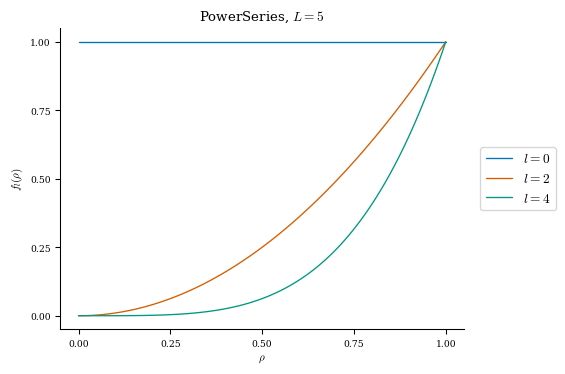

In [3]:
power_series = PowerSeries(L=5)
plot_basis(power_series);

### Fourier Series

The magnetic axis is given as a Fourier series in the normalized toroidal angle $N_{FP}\zeta$

$$
   \mathcal{F}_{n}(\zeta) = \begin{cases}
   \cos(|n|N_{FP}\zeta) &\text{for }n\ge0 \\
   \sin(|n|N_{FP}\zeta) &\text{for }n<0. \\
   \end{cases}
$$

The Fourier coefficients of a function $f(\zeta)$ are given by:

$$
    f_{n} = \frac{\alpha}{2\pi} \int_{0}^{2\pi} f(\zeta) \mathcal{F}_{n}(\zeta) d\zeta
$$

$$
   \alpha = \begin{cases}
   0 &\text{for }n=0 \\
   2 &\text{for }n\ne 0. \\
   \end{cases}
$$

A `FourierSeries` is parameterized by a non-negative integer `N`, the maximum absolute value of the toroidal mode number and a positive integer `NFP`, the number of field periods. The basis will have mode numbers $n \in \{-N...N\}$. You can also specify the optional argument `sym` to be one of `cos` or `sin` to impose $\cos(m\theta - n\zeta)$ or $\sin(m\theta - n\zeta)$ symmetry.

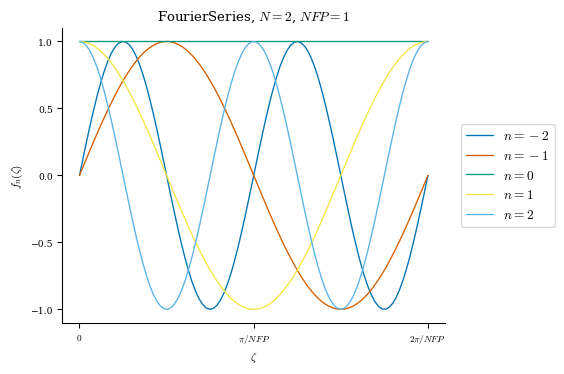

In [4]:
fourier_series = FourierSeries(N=2, NFP=1)
plot_basis(fourier_series);

### Double Fourier Series

A double Fourier series in the poloidal angle $\theta$ and the normalized toroidal angle $N_{FP}\zeta$ is used to specify the shape of the plasma boundary on the last closed flux surface. 

$$
   \mathcal{G}^{m}_{n}(\theta,\zeta) = \begin{cases}
   \cos(|m|\theta)\cos(|n|N_{FP}\zeta) &\text{for }m\ge0, n\ge0 \\
   \cos(|m|\theta)\sin(|n|N_{FP}\zeta) &\text{for }m\ge0, n<0 \\
   \sin(|m|\theta)\cos(|n|N_{FP}\zeta) &\text{for }m<0, n\ge0 \\
   \sin(|m|\theta)\sin(|n|N_{FP}\zeta) &\text{for }m<0, n<0.
   \end{cases}
$$

The Fourier coefficients of a function $f(\theta,\zeta)$ are given by:

$$f^{m}_{n} = \frac{\alpha}{4\pi^2} \int_{0}^{2\pi} \int_{0}^{2\pi} f(\theta,\zeta) \mathcal{G}^{m}_{n}(\theta,\zeta) d\theta d\zeta$$

$$
   \alpha = \begin{cases}
   0 &\text{for }m=0, n=0 \\
   2 &\text{for }m=0, n\ne0 \\
   2 &\text{for }m\ne0, n=0 \\
   4 &\text{for }m\ne0, n\ne0. \\
   \end{cases}
$$


A `DoubleFourierSeries` is parameterized by two non-negative integers `M` and `N`, the maximum poloidal and toroidal mode numbers, a positive integer `NFP`, the number of field periods. The basis will have mode numbers $m \in \{-M...M\}$  and $n \in \{-N...N\}$. You can also specify the optional argument `sym` to be one of `cos` or `sin` to impose $\cos(m\theta - n\zeta)$ or $\sin(m\theta - n\zeta)$ symmetry.

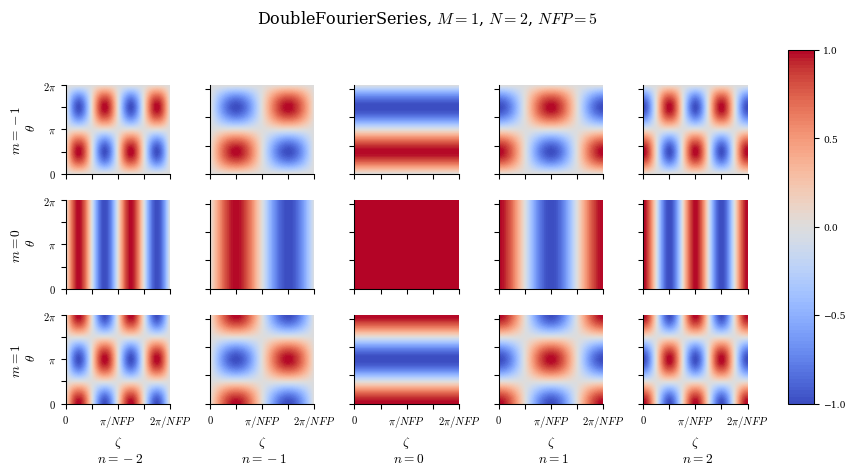

In [5]:
double_fourier = DoubleFourierSeries(M=1, N=2, NFP=5)
plot_basis(double_fourier);

### Zernike Polynomials and Fourier-Zernike basis

The flux surface positions $R(\rho,\theta,\zeta)$, $Z(\rho,\theta,\zeta)$ and stream function $\lambda(\rho,\theta,\zeta)$ are represented by a combined Fourier-Zerniek basis, with a standard Fourier series in the toroidal direction and a Zernike polynomial in the $(\rho,\theta)$ plane. 

Zernike polynomials are a set of 2d orthogonal basis functions on the unit disc and are ideal for toroidal equilibria as they automatically satisfy the necessary regularity conditions at the magnetic axis.

The Zernike polynomials are given by:
$$
   \mathcal{Z}^{m}_{l}(\rho,\theta) = \begin{cases}
   \mathcal{R}^{|m|}_l (\rho) \cos(|m|\theta) &\text{for }m\ge0 \\
   \mathcal{R}^{|m|}_l (\rho) \sin(|m|\theta) &\text{for }m\lt0 \\
   \end{cases}
$$

Where the radial part is a shifted Jacobi polynomial:

$$
    \mathcal{R}^{|m|}_l(\rho) = \sum_{s=0}^{(l-|m|)/2} \frac{(-1)^s (l-s)!}{s![(l-|m|)/2 - s]![(l-|m|)/2+s]!} \rho^{l-2s}
$$

A `FourierZernikeBasis` is initialized with 3 non-negative integers `L`. `M`, and `N` specifying the radial, poloidal, and toroidal resolution respectively, along with a positive integer `NFP` for the number of fields periods. It also accepts the same `sym` parameter as the Fourier basis functions for imposing stellarator symmetry. 

Note that due to the way the Zernike basis couples radial and poloidal modes, the radial resolution `L` is not the maximum radial mode number, but instead the maximum difference between radial mode number `l` and poloidal mode number `m`.
Additionally, the Zernike basis functions also accept an argument `spectral_indexing` (one of `ansi` or `fringe`) which controls how the Zernike pyramid is filled in. For `L=0` both methods are equivalent, but for high values of `L` they differ somewhat, with `fringe` indexing generally giving higher radial resolution for a given poloidal resolution. 

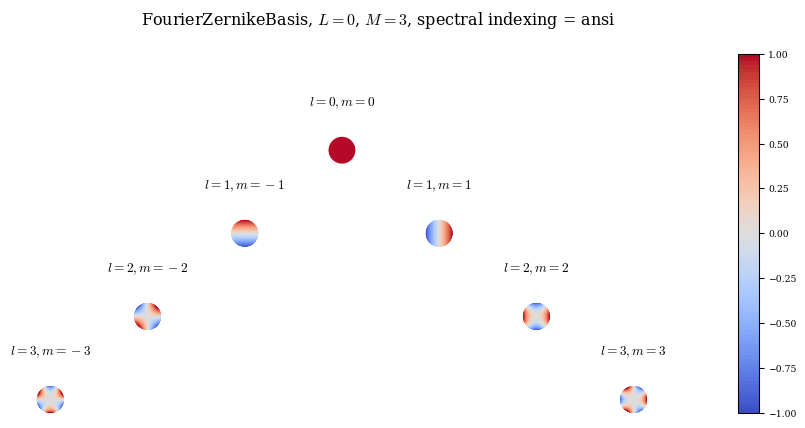

In [6]:
ansi_zern0 = FourierZernikeBasis(L=0, M=3, N=0, spectral_indexing='ansi')
plot_basis(ansi_zern0);

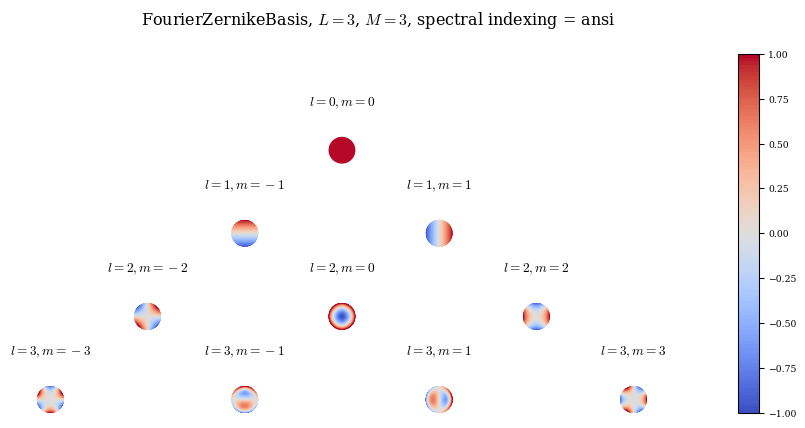

In [7]:
ansi_zern3 = FourierZernikeBasis(L=3, M=3, N=0, spectral_indexing='ansi')
plot_basis(ansi_zern3);

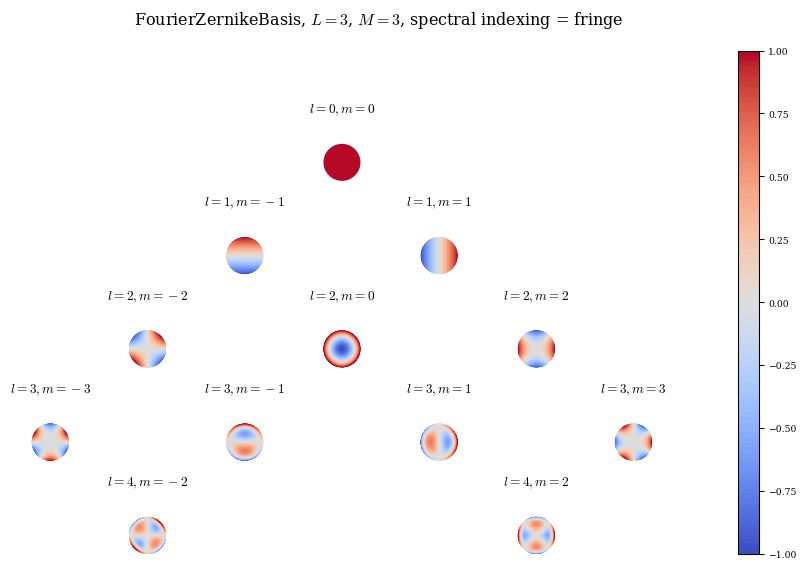

In [8]:
fringe_zern3 = FourierZernikeBasis(L=3, M=3, N=0, spectral_indexing='fringe')
plot_basis(fringe_zern3);

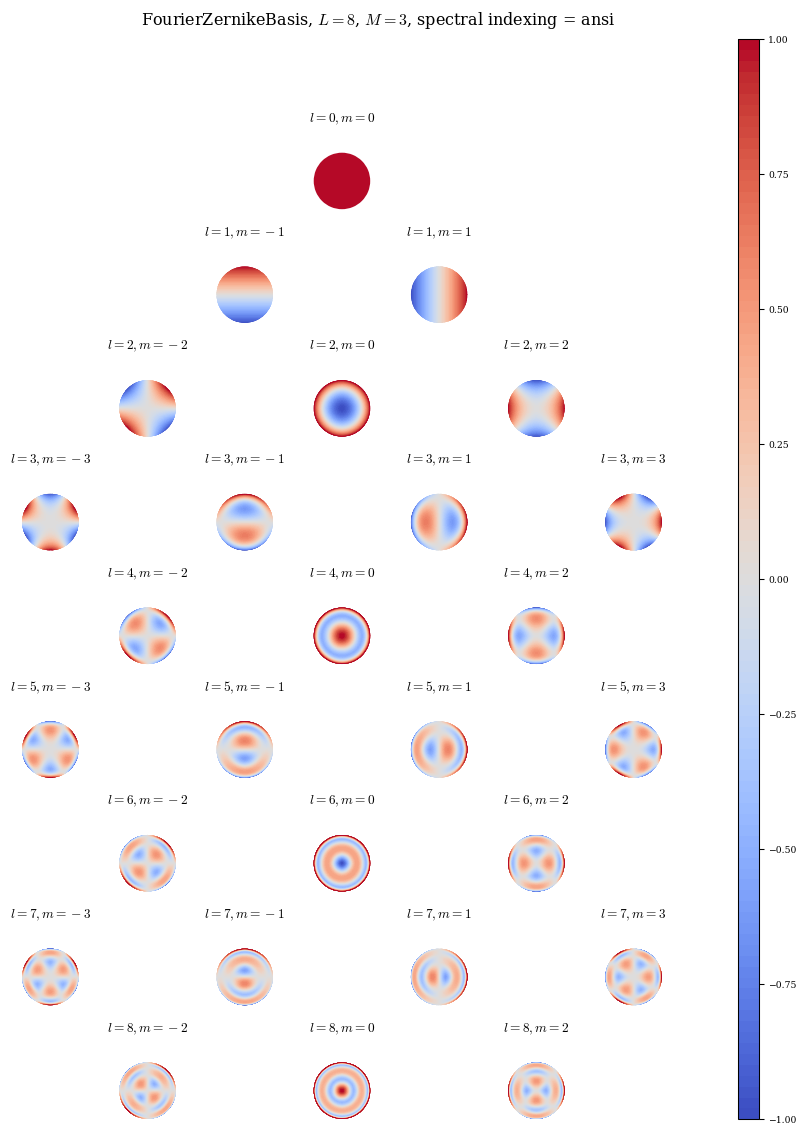

In [9]:
ansi_zern8 = FourierZernikeBasis(L=8, M=3, N=0, spectral_indexing='ansi')
plot_basis(ansi_zern8);

In [ ]:
fringe_zern8 = FourierZernikeBasis(L=8, M=3, N=0, spectral_indexing='fringe')
plot_basis(fringe_zern8);

## Collocation grids

The two primary attributes of any grid are `grid.nodes` and `grid.weights`.

`grid.nodes` is a $k \times 3$ array of the node locations in straight field line coordinates $(\rho,\theta,\zeta)$

`grid.weights` is a $k \times 1$ array giving approximate or exact quadrature weights for each node.

### Linear Grid

The simplest collocation grid is one that is linearly spaced in all coordinates $(\rho,\theta,\zeta)$. It accepts 3 non-negative integer arguments in two different formats: 

`L`, `M`, `N` specify the spectral resolution in each dimension. For example, `L=4` would give 5 radial grid points corresponding to a polynomial up to order $\rho^4$. `M=2` would give 5 poloidal grid points corresponding to the 5 Fourier basis functions up to order $\sin(2\theta)$ and $\cos(2\theta)$. 

`rho`, `theta`, `zeta` directly specify the number of linearly spaced grid points in each dimension, if passed as integers. Alternatively, these inputs can be used to manually specify the arrays of nodes. 

The number of field periods is also input as a positive integer `NFP`. 

The `weights` attribute for the linear grid is based on the spacing between nodes: $w_j = d\rho_j d\theta_j d\zeta_j$

A linear grid is mostly used for plotting and other analysis, but is generally innefficient and innacurate when used to solve the objective.

In [ ]:
linear_grid = LinearGrid(rho=10, M=4, N=0)
plot_grid(linear_grid);

### Quadrature Grid

The quadrature grid is designed to exactly integrate the Fourier-Zernike basis functions. The poloidal and toroidal nodes are the standard Fourier pattern, while the radial positions are the roots of shifted Jacobi polynomials, which cluster points near the edge and axis. The `weights` attribute provides the exact quadrature weights.

A `QuadratureGrid` is initialized with 3 non-negative integers `L`, `M`, `N` which are the order of the basis functions that the grid should integrate exactly, and a positive integer `NFP` giving the number of field periods. The number of nodes will be $(L+1)(2M+1)(2N+1)$

While the quadrature grid is in most cases the most accurate, it does so at the expense of using a relatively large number of nodes. For most purposes the concentric grids (see below) offer better performance.

In [ ]:
quad = QuadratureGrid(L=10, M=10, N=0)
plot_grid(quad);

### Concentric grids

Concentric grids are designed to be efficient when solving the force balance equations, with the number of poloidal modes proportional to the distance from the axis so that each node occupies roughly the same volume in straight field line space. The `weights` attribute uses local volume elements to approximate quadrature weights in a similar way to the `LinearGrid`. For a given resolution, a concentric grid will use roughly half the nodes of a quadrature grid.


A `ConcentricGrid` is initialized with three non-negative integers `L`, `M` and `N`, the resolution of the basis functions to integrate, and a positive integer `NFP` giving the number of field periods. Optionally, a `node_pattern` can be given to specify the pattern for the radial nodes 

There are 3 options for `node_pattern`:

- `jacobi` (default) uses the roots of the shifted jacobi polynomials and concentrates nodes near the edge and axis
- `cheb1` uses the roots of the Chebyshev-Gauss-Lobatto nodes scaled to $\rho$=[0,1], which concentrates nodes near the edge and the axis
- `cheb2` uses the roots of the Chebyshev-Gauss-Lobatto nodes scaled to $\rho$=[-1,1], which concentrates nodes at the edge
- `ocs` uses the node pattern from [1] designed to minimize the condition number of the interpolation matrix, used for fitting data back to a Zernike basis

[1] Ramos-Lopez, et al “Optimal Sampling Patterns for Zernike Polynomials.” Applied Mathematics and Computation 274 (February 2016): 247–57. https://doi.org/10.1016/j.amc.2015.11.006.


In [ ]:
jacobi = ConcentricGrid(L=10, M=10, N=0, node_pattern='jacobi')
plot_grid(jacobi);

In [ ]:
cheb1 = ConcentricGrid(L=10, M=10, N=0, node_pattern='cheb1')
plot_grid(cheb1);

In [ ]:
cheb2 = ConcentricGrid(L=10, M=10, N=0, node_pattern='cheb2')
plot_grid(cheb2);

In [ ]:
cheb2 = ConcentricGrid(L=10, M=10, N=0, node_pattern='ocs')
plot_grid(cheb2);